<a href="https://colab.research.google.com/github/GitAmitesh/SkinDiseaseClassificationCNN/blob/main/model_3_mobileNet_87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from scipy import stats

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.regularizers import l2


In [2]:
!fusermount -u drive
drive.mount('/content/drive')

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


In [3]:
# Path to your .pkl file
file_path = "/content/drive/MyDrive/HAM10000/final_processed_ham_metadata.pkl"

# Load the DataFrame
df = pd.read_pickle(file_path)

# Check the result
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,lesion_type,lesion_type_idx,image_array
0,HAM_0006018,ISIC_0033486,bkl,histo,75.0,male,trunk,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2,"[[[0.62352943, 0.58431375, 0.61960787], [0.619..."
1,HAM_0000206,ISIC_0033925,mel,histo,65.0,female,upper extremity,/content/drive/MyDrive/HAM10000/HAM10000_image...,Melanoma,5,"[[[0.7529412, 0.57254905, 0.654902], [0.745098..."
2,HAM_0000673,ISIC_0029659,akiec,histo,70.0,female,face,/content/drive/MyDrive/HAM10000/HAM10000_image...,Actinic keratoses,0,"[[[0.75686276, 0.4862745, 0.4862745], [0.73333..."
3,HAM_0000000,aug_normal_skin_0298,ns,none,45.0,unknown,unknown,/content/drive/MyDrive/HAM10000/normal_skin_im...,Normal skin,7,"[[[0.30980393, 0.23529412, 0.1764706], [0.3058..."
4,HAM_0005505,ISIC_0031743,akiec,histo,50.0,male,upper extremity,/content/drive/MyDrive/HAM10000/HAM10000_image...,Actinic keratoses,0,"[[[0.015686275, 0.011764706, 0.003921569], [0...."


In [4]:
# Constants
SIZE = (150, 200, 3)
num_classes = 8
image_shape = (SIZE[0], SIZE[1], SIZE[2])
image_array_path = "/content/drive/MyDrive/HAM10000/final_processed_image_arrays.npy"  # This should be pre-saved memmap file path

# Load memory-mapped image array (not in RAM)
num_images = len(df)
image_arrays_loaded = np.load(image_array_path, mmap_mode='r')

# Labels
Y = df['lesion_type_idx']
Y_cat = to_categorical(Y, num_classes=num_classes)

# Train-test split (indices only)
train_idx, test_idx = train_test_split(np.arange(num_images), test_size=0.25, random_state=42)

In [5]:
# -----------------------------
# Custom Data Generator
# -----------------------------
class MemmapImageGenerator(Sequence):
    def __init__(self, memmap, labels, indices, batch_size=32):
        self.memmap = memmap
        self.labels = labels
        self.indices = indices
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x = self.memmap[batch_ids]
        batch_y = self.labels[batch_ids]
        if batch_x is None or batch_y is None:
            raise ValueError("Generator is returning None values.")
        return batch_x, batch_y

# Create training and validation generators
batch_size = 64
train_gen = MemmapImageGenerator(image_arrays_loaded, Y_cat, train_idx, batch_size=batch_size)
test_gen = MemmapImageGenerator(image_arrays_loaded, Y_cat, test_idx, batch_size=batch_size)

In [42]:
# Define top-k accuracy metrics
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [14]:
# Load MobileNet without top layers
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(150, 200, 3), pooling='avg')

# Freeze all layers except the last 23
for layer in base_model.layers[:-23]:
    layer.trainable = False

# Add custom head
x = base_model.output
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
output = Dense(8, activation='softmax')(x)

<ipython-input-14-a57303ddb116>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(150, 200, 3), pooling='avg')


In [15]:
# Create model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', top_2_accuracy, top_3_accuracy])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                              verbose=1, mode='min', min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks_list = [reduce_lr, early_stop]

# Train the model using your memory-efficient generators
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=test_gen,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 479ms/step - accuracy: 0.5979 - loss: 1.6183 - top_2_accuracy: 0.7493 - top_3_accuracy: 0.8419 - val_accuracy: 0.4695 - val_loss: 3.2639 - val_top_2_accuracy: 0.7153 - val_top_3_accuracy: 0.8398 - learning_rate: 0.0010
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 64s 396ms/step - accuracy: 0.8131 - loss: 0.8352 - top_2_accuracy: 0.9318 - top_3_accuracy: 0.9750 - val_accuracy: 0.6187 - val_loss: 1.7888 - val_top_2_accuracy: 0.8208 - val_top_3_accuracy: 0.9114 - learning_rate: 0.0010
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 85s 416ms/step - accuracy: 0.8933 - loss: 0.5845 - top_2_accuracy: 0.9673 - top_3_accuracy: 0.9913 - val_accuracy: 0.6270 - val_loss: 1.6629 - val_top_2_accuracy: 0.8052 - val_top_3_accuracy: 0.9108 - learning_rate: 0.0010
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 58s 414ms/step - accuracy: 0.9120 - loss: 0.4590 - top_2_accuracy: 0.9803 - top_3_accuracy: 0.9957 - val_accuracy: 0.6963 - val_loss: 1.4893 - val_top_2_accuracy: 0.8924 -

In [45]:
save_path = "/content/drive/MyDrive/mobilenet_model_88.keras"
model.save(save_path)

In [46]:
# Evaluate
val_loss, val_acc, val_top_2_acc, val_top_3_acc = model.evaluate(test_gen)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)
print("Top-2 Accuracy:", val_top_2_acc)
print("Top-3 Accuracy:", val_top_3_acc)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8892 - loss: 0.5810 - top_2_accuracy: 0.9631 - top_3_accuracy: 0.9875
Validation Loss: 0.6347380876541138
Validation Accuracy: 0.8791208863258362
Top-2 Accuracy: 0.959373950958252
Top-3 Accuracy: 0.9856809973716736


In [47]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
# Step 1: Collect all predictions and true labels from the test generator
y_true = []
y_pred = []

for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    preds = model.predict(x_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.8775181334732678
Recall: 0.8791208791208791
F1-Score: 0.8776025513306626


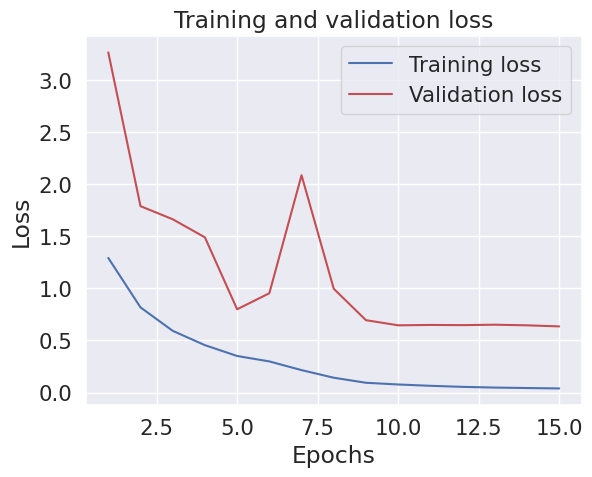

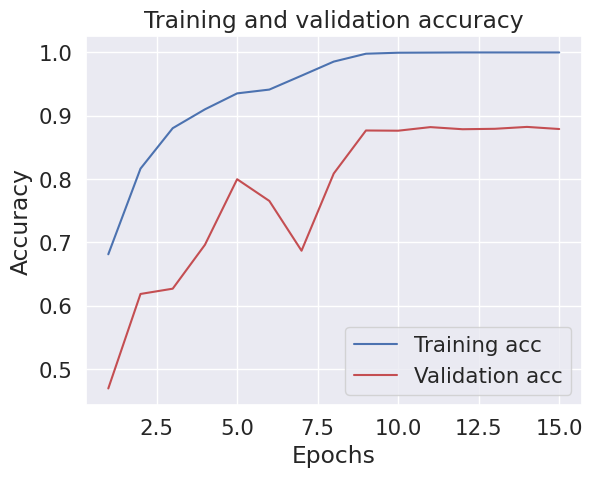

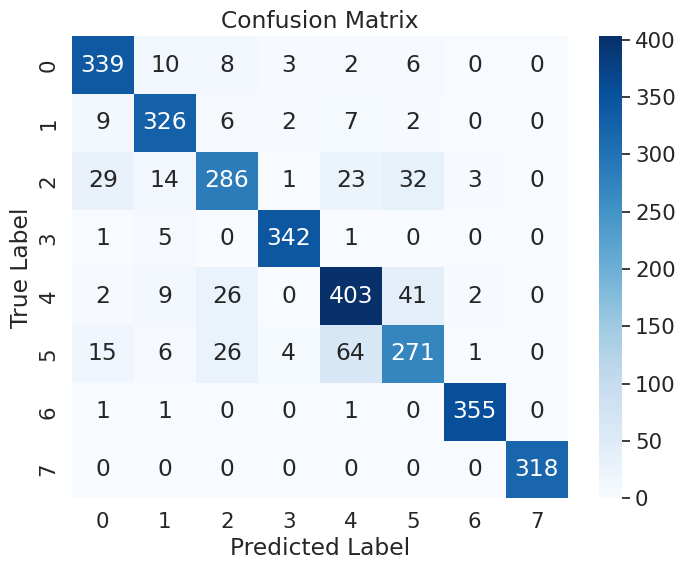

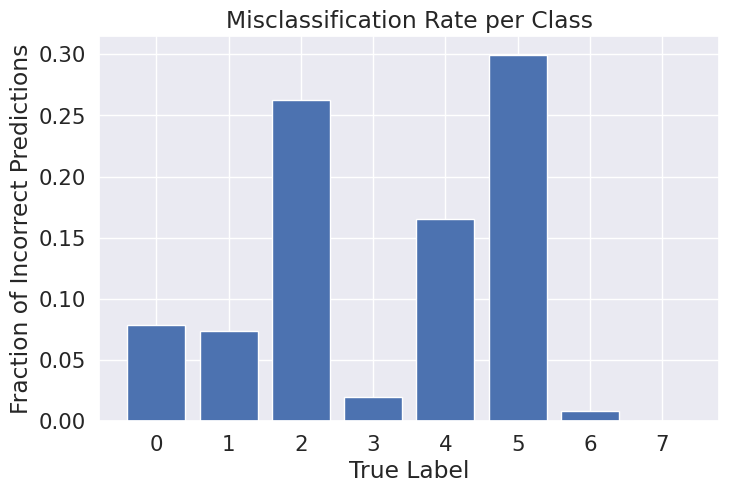

In [50]:
# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Step 1: Collect all predictions and true labels from the test generator
y_true = []
y_pred = []

for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    preds = model.predict(x_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 4: Plot fraction of incorrect predictions per class
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(cm)), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect Predictions')
plt.title('Misclassification Rate per Class')
plt.grid(True)
plt.show()

In [52]:
import numpy as np

# True Positives are the diagonal elements
tp = np.diag(cm)

# False Positives are the sum of each column minus the diagonal element
fp = np.sum(cm, axis=0) - tp

# Display TP and FP for each class
for i in range(len(tp)):
    print(f"Class {i}: TP = {tp[i]}, FP = {fp[i]}, Total = {tp[i]+fp[i]}")


Class 0: TP = 339, FP = 57, Total = 396
Class 1: TP = 326, FP = 45, Total = 371
Class 2: TP = 286, FP = 66, Total = 352
Class 3: TP = 342, FP = 10, Total = 352
Class 4: TP = 403, FP = 98, Total = 501
Class 5: TP = 271, FP = 81, Total = 352
Class 6: TP = 355, FP = 6, Total = 361
Class 7: TP = 318, FP = 0, Total = 318


In [51]:
# Classification report (Precision, Recall, F1)
print("Classification Report:\n", classification_report(y_true, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       368
           1       0.88      0.93      0.90       352
           2       0.81      0.74      0.77       388
           3       0.97      0.98      0.98       349
           4       0.80      0.83      0.82       483
           5       0.77      0.70      0.73       387
           6       0.98      0.99      0.99       358
           7       1.00      1.00      1.00       318

    accuracy                           0.88      3003
   macro avg       0.88      0.89      0.88      3003
weighted avg       0.88      0.88      0.88      3003



In [ ]:
from tensorflow.keras.models import load_model
# Path to your saved model
model_path = '/content/drive/MyDrive/mobilenet_best_model.keras'

# Load the model
model_loaded = load_model(model_path, custom_objects={
    'top_2_accuracy': top_2_accuracy,
    'top_3_accuracy': top_3_accuracy
})